# Capital Bikeshare Project

## Step 1: Loading data, quality check

In [206]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import time

from sklearn.utils import resample

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import RFE

from sklearn.dummy import DummyRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures

from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
df_raw = pd.read_csv('train_bike.csv')

In [3]:
df_raw.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


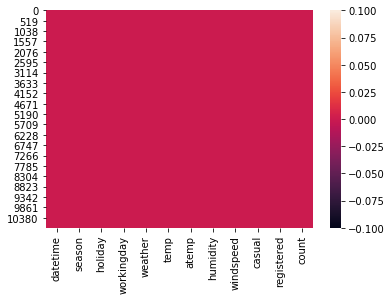

In [5]:
# check for missing data

sns.heatmap(df_raw.isna())

## Train-test split

From a first glance, we don't have any missing values. 

Before any further analysis, I'm going to split between the training and test sets.

In [232]:
y = df_raw['count']

X = df_raw.drop(['count'], axis = 1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((8164, 11), (2722, 11), (8164,), (2722,))

In [7]:
# I'm renaming Xtrain because I want to do some manipulations that I will add in separate steps of feature encoding
# I also want to investigate how y behaves, so I'm adding it back in for exploration purposes
df = Xtrain.join(ytrain)

# make sure it is sorted in chronological order
df = df.sort_values(by = 'datetime')

### Remove casual and registered riders

Since casual + registered = count, I need to remove these from the data I'm using for my model. (Doing this here so I don't forget later...)

In [8]:
Xtrain = Xtrain.drop(['casual', 'registered'], axis = 1)
Xtest = Xtest.drop(['casual', 'registered'], axis = 1)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((8164, 9), (2722, 9), (8164,), (2722,))

## Step 2: Exploring the Capital Bikeshare data set

### Aims of data exploration

- Get a sense of the data

Questions to address (from textbook):

- Which factors contribute most to the number of bicycles being checked out out over the course of a given day?
- How much of an impact does weather have on demand?
- How does the behavior of casual users differ from subscribers?


Aims of the project:

“Given the forecasted weather conditions, how many bicycles can we expect to be checkout this Saturday at 2pm?”

Important information to take into account for prediction:
- Effect of weather
- Effect of day (weekday vs. weekend)
- Effect of time (2 pm)

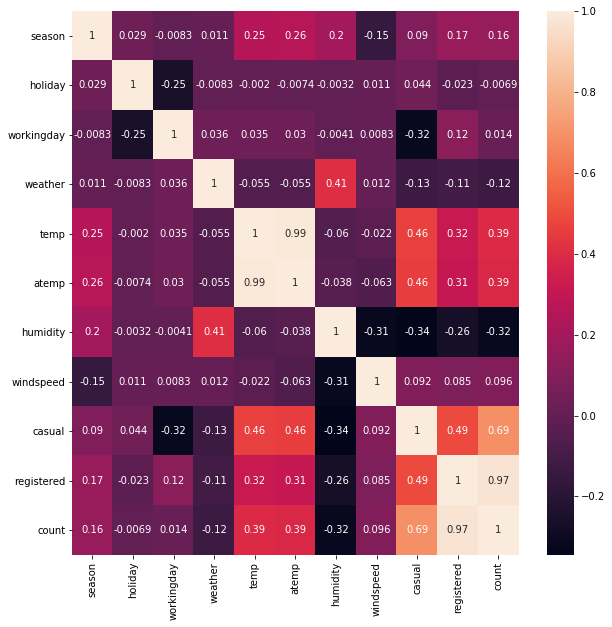

In [9]:
# quick look at correlations: what columns is "count" (= no. bikes rented on a given day) correlated with?

plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), annot = True)

Some quick notes:
- (disregard casual/registered in this plot as casual + registered = count)
- workingday/holiday and casual are linked (suggesting the workday/weekend distinction is important for casual users; less so for registered users)
- temperature is  correlated with count; "weather" less so (possibly because it is a less granular measure and therefore captures data trends at a higher level); humidity is not correlated (this is surprising given my experience of DC summers, but it's possible that humidity is confounded with season); windspeed is somewhat correlated


### Understanding the data

- Is the distinction between actual and felt temperature important? (Is felt temperature going to incorporate values from wind and humidity data, potentially introducing a confound?)

### How to assess strength of factors that affect count:

- linear regression analysis with p-values

### Plotting: Ridership Over Time By Rider Category

Start by getting a sense of how the two categories of ridership compare in their behaviour, and how ridership has evolved in the two-year time span covered by this data set.

In [10]:
# Create new df with totals aggregated over each day

# first separate out hour and day in new columns

# set index as column

# df.reset_index(inplace = True)

df['hour'] = pd.to_datetime(df['datetime']).dt.hour

df['date'] = pd.to_datetime(df['datetime']).dt.date

df['month'] = pd.to_datetime(df['datetime']).dt.month

df['year'] = pd.to_datetime(df['datetime']).dt.year

# df.set_index('datetime', inplace = True)

In [11]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,date,month,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0,2011-01-01,1,2011
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,2011-01-01,1,2011
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,5,2011-01-01,1,2011
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,6,2011-01-01,1,2011
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,7,2011-01-01,1,2011


In [12]:
# now count totals by day

days = df.groupby(['date']).sum()
days.reset_index(inplace = True)
days

,date,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month,year
0,2011-01-01,18,0,0,29,266.50,337.865,1454,228.0010,310,552,862,220,18,36198
1,2011-01-02,15,0,0,27,220.58,259.840,977,256.9919,81,449,530,189,15,30165
2,2011-01-03,17,0,17,17,132.84,156.070,760,286.0096,71,887,958,197,17,34187
3,2011-01-04,18,0,18,19,151.70,193.940,1053,207.0099,103,1223,1326,225,18,36198
4,2011-01-05,17,0,17,17,160.72,200.775,756,191.0103,57,1081,1138,192,17,34187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,2012-12-15,72,0,0,24,245.18,309.090,1153,136.0100,683,3506,4189,221,216,36216
452,2012-12-16,72,0,0,38,266.50,332.560,1526,111.9972,392,2348,2740,209,216,36216
453,2012-12-17,68,0,17,35,273.88,340.145,1527,110.0006,188,3981,4169,200,204,34204
454,2012-12-18,68,0,17,21,284.54,345.445,1104,278.0165,308,3460,3768,204,204,34204


In [13]:
days['date'].min()

datetime.date(2011, 1, 1)

In [14]:
firstdate = days['date'][0]

In [15]:
lastdate = days['date'][len(days['date'])-1]

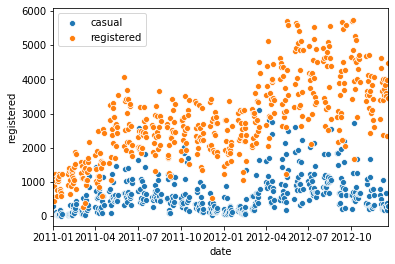

In [16]:
# plot total rentals across time, separated by ridership

sns.scatterplot(x = 'date', y = 'casual', data = days, label = 'casual')
sns.scatterplot(x = 'date', y = 'registered', data = days, label = 'registered')
plt.xlim(firstdate, lastdate)    # xlim = first and last date in data set
plt.legend()

Conclusions from this plot:
- Steadily increasing overall ridership over the two-year time period.
- Surges in the summer months across both ridership groups.
- Rentals by registered riders overall consistently higher per day than rentals by casual riders -- though the two groups sometimes overlap in their rental numbers.

In [17]:
# Aggregate across months

# 2011

months_2011 = df.loc[df['year'] == 2011]

months_2011 = months_2011.groupby(['month']).sum()
months_2011.reset_index(inplace = True)
months_2011

# 2012

months_2012 = df.loc[df['year'] == 2012]

months_2012 = months_2012.groupby(['month']).sum()
months_2012.reset_index(inplace = True)
months_2012

,month,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,year
0,1,345,40,209,468,3793.32,4589.365,19040,5358.1240,4195,39326,43521,4040,694140
1,2,334,0,223,521,4072.12,5005.280,19776,4157.1222,4416,45094,49510,3867,672008
2,3,329,0,221,454,5836.76,6952.165,18881,4938.1077,13143,56476,69619,3858,661948
3,4,678,17,228,423,6700.22,7958.170,15272,5125.0846,21590,66166,87756,3938,682068
4,5,688,0,254,526,8208.20,9578.135,22340,4122.0075,19077,70926,90003,3924,692128
5,6,704,0,241,466,9147.10,10531.955,20654,4433.1019,22460,80857,103317,4045,708224
6,7,1014,18,227,444,10744.46,12132.685,18970,3319.0661,19019,75584,94603,3927,680056
7,8,1044,0,238,466,10357.42,11432.755,22259,3964.0684,21558,77431,98989,3993,700176
8,9,951,18,196,440,8356.62,9652.420,21507,3705.1201,19336,69696,89032,3619,637804
9,10,1368,18,259,526,7188.12,8482.555,23023,3965.1203,15782,82255,98037,4001,688104


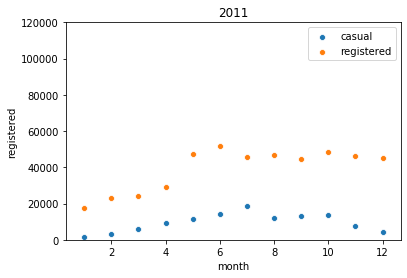

Text(0.5, 1.0, '2012')

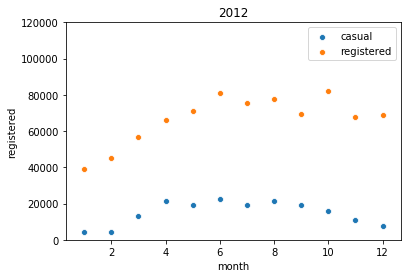

In [18]:
# Plot ridership by month each year

sns.scatterplot(x = 'month', y = 'casual', data = months_2011, label = 'casual')
sns.scatterplot(x = 'month', y = 'registered', data = months_2011, label = 'registered')
plt.ylim(0, 120_000)
plt.legend()
plt.title('2011')
plt.show()
plt.close()


sns.scatterplot(x = 'month', y = 'casual', data = months_2012, label = 'casual')
sns.scatterplot(x = 'month', y = 'registered', data = months_2012, label = 'registered')
plt.ylim(0, 120_000)
plt.legend()
plt.title('2012')

### Plotting: Weekdays and Holidays

- How does weekday and holiday status affect bike rentals?

- Do we need to break out holidays from weekends? Or can we do a work day/not work day distinction?

#### Weekdays Plots
- Choice: Box plot to show range of distribution
- Secondary choice: plot by season

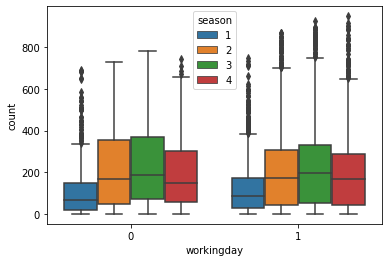

In [19]:
# Plot rentals: weekday vs. non weekday
sns.boxplot(x = 'workingday', y = 'count', hue = 'season', data = df)

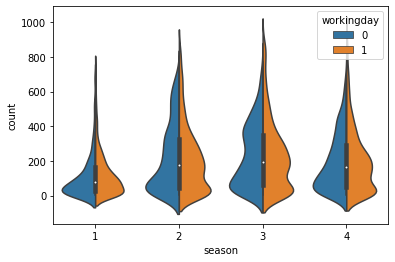

In [20]:
# asymmetric violin plot

sns.violinplot(x = 'season', y = 'count', hue = 'workingday',
                    data = df, split=True)

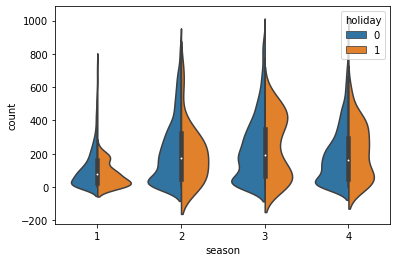

In [21]:
sns.violinplot(x = 'season', y = 'count', hue = 'holiday',
                    data = df, split=True)

Conclusions from comparing holiday and workingday rental volume:
- Holidays (1; orange in this plot) behave similarly to non-working days (0; blue in the plot before)
- For simplicity I'll distinguish between workdays and non-workdays

Some conclusions from this:
- Seasonal patterns are similar across day type -- with highest no. of rentals in summer, and lowest ones in winter
- Long-tailed distribution for most season
- These graphs doesn't let us see difference between the casual and registered ridership. For this purpose, an asymmetrical violin plot could be helpful.
- The violin plot suggests that there are bimodal distributions: in summer, it seems like the counts are either very low or quite high. Except in winter, workday distributions are always bimodal. Since this is hour-by-hour data, this looks like a "rush hour" kind of phenomenon.

Another thought:
- This data is all hour by hour. 
- To get a more coarse-grained overview of patterns of demand, I might want to look at averages over a full day (midnight to midnight).
- And we haven't looked at ridership yet.

### Plotting: Time of day
- For each type of day, plot activity
- Possibility: plot by season
- Another possibility: plot by casual/registered user?
- Not reflected in heatmap as this collapsed across days (but data points are available for every hour)

In [22]:
# Creating a data set that is grouped by hours
# disregarding season for now but taking into account the workingday difference

hours = df.groupby(['hour', 'workingday']).sum()
hours.reset_index(inplace = True)
hours.head()

# hours['hour'].unique()
# check if hours reported as 24-h clock; answer: yes!

,hour,workingday,season,holiday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,year
0,0,0,261,8,144,1989.32,2353.025,7109,1219.0516,1818,8227,10045,667,217239
1,0,1,614,0,339,4701.88,5534.120,16667,2647.1231,1799,7199,8998,1602,486777
2,1,0,290,12,167,2175.46,2573.515,8005,1075.0217,1566,6856,8422,756,231325
3,1,1,577,0,332,4345.18,5132.575,16110,2393.0725,802,2871,3673,1501,458623
4,2,0,251,8,140,1787.60,2120.460,6882,1028.0480,1087,4293,5380,651,203160


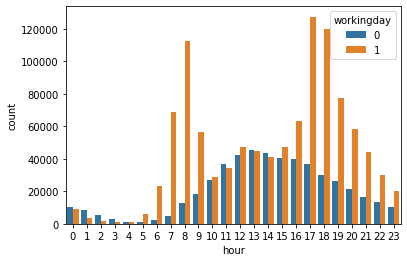

In [23]:
# Plot as bar chart

sns.barplot(x = 'hour', y = 'count', data = hours, hue = 'workingday')

**Conclusions from this plot:**

- Patterns for bike rental numbers for working/non-working days are very similar between midnight and 5 am.
- Patterns diverge between 5 am - midnight.
- On work days, there are two big spikes in bike rentals peaking at 8 and 6 pm (before and after a 9-5 work day). Bimodal distribution.
- On non-work days, bike rentals build gradually, peaking at noon. Unimodal distribution. The peak of the non-working day rental no. is equivalent to the trough between the two working day peaks.

**Conclusion: People's commute to work may be a significant factor in bike rentals.**

Next up: If work schedules impact bike rentals, we may see differences between registered and casual ridership patterns.

### Plotting: Ridership vs. time of day

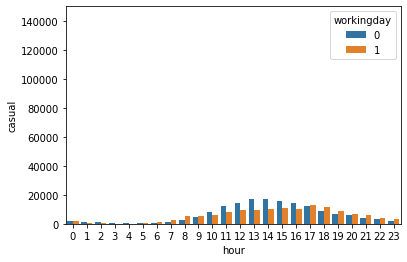

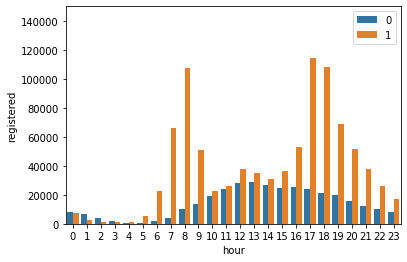

In [24]:
# plot

sns.barplot(x = 'hour', y = 'casual', data = hours, hue = 'workingday')
plt.ylim(0, 150_000)
plt.show()
plt.close()

sns.barplot(x = 'hour', y = 'registered', data = hours, hue = 'workingday')
plt.ylim(0, 150_000)
plt.legend()



**Conclusions from these plots:**

- Registered ridership dwarfs casual ridership.
- The distribution pattern for non-working days is the same for registered and casual riders, though there are many more registered riders using bikes on non-working days (looks like a factor of about 10).

### Plotting: Weather

Look at how seasonal weather patterns affect total bike rentals. (No separation for now between casual and registered riders.)
- Different plot for each season (easier to grasp); same x and y axis
- For each season, plot relationship of rentals with:
    - Weather (1, 2, 3, 4)
    - Temperature (real and felt)
    - Humidity

In [25]:
# Create df of mean rentals by season by weather

weather = df.groupby(['season', 'weather']).mean()
weather = weather[['casual', 'registered', 'count']]
weather.reset_index(inplace = True)

weather

,season,weather,casual,registered,count
0,1,1,18.300530,109.656321,127.956851
1,1,2,13.901079,92.111511,106.012590
2,1,3,3.443038,59.075949,62.518987
3,1,4,6.000000,158.000000,164.000000
4,2,1,53.560505,183.449146,237.009651
5,2,2,41.809963,151.107011,192.916974
6,2,3,21.141104,105.558282,126.699387
7,3,1,54.438034,187.683048,242.121083
8,3,2,50.585812,181.453089,232.038902
9,3,3,35.213793,119.572414,154.786207


In [26]:
df.groupby(['season', 'weather'])['count'].count()

season  weather
1       1          1321
        2           556
        3           158
        4             1
2       1          1347
        2           542
        3           163
3       1          1404
        2           437
        3           145
4       1          1290
        2           620
        3           180
Name: count, dtype: int64

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


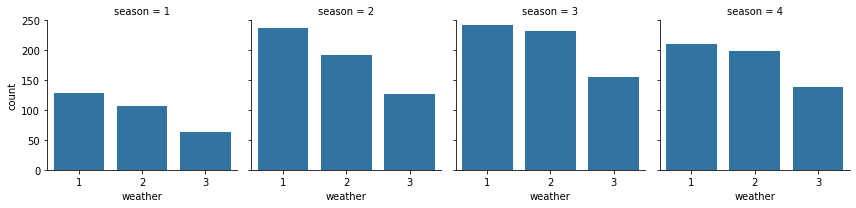

In [27]:
# Plotting: Weather

g = sns.FacetGrid(weather, col = 'season', ylim = (0, 250))
g = g.map(sns.barplot, 'weather', 'count')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


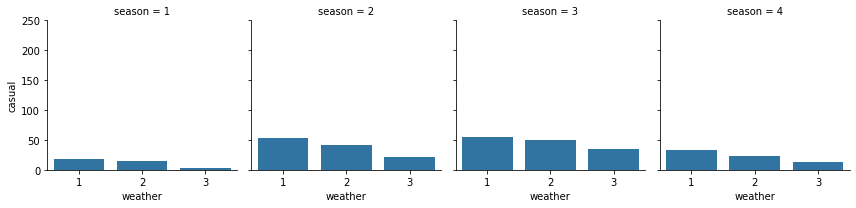

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


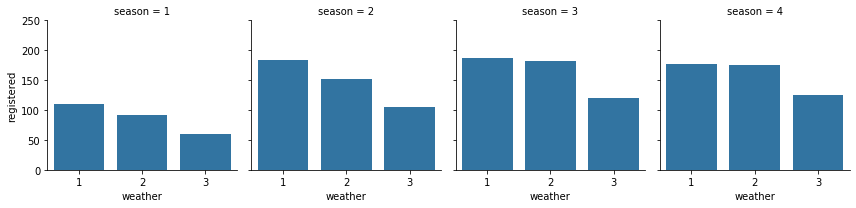

In [28]:
# Plotting: Weather II

g = sns.FacetGrid(weather, col = 'season', ylim = (0, 250))
g = g.map(sns.barplot, 'weather', 'casual')
plt.show()

g = sns.FacetGrid(weather, col = 'season', ylim = (0, 250))
g = g.map(sns.barplot, 'weather', 'registered')

Conclusions from these plots:
- As we already know, casual ridership is really low
- Across all seasons, the worse the weather (the higher the number) the lower, on average, the rentals in a given hour across the day
- In this data set there is only one recorded instance of type 4 weather, so it is not shown in the bar plots

#### Weather: Humidity

My firsthand experience of the Mid-Atlantic suggests that humidity affects rental numbers differently across seasons. Specifically, high humidity in summer feels atrocious, and you wouldn't want to be out on a bike, but in the coldest season (spring), it doesn't especially matter. Let's find out!

In [29]:
# Create a new column binning humidity

bins = pd.IntervalIndex.from_tuples([(0, 10), (10.1, 20), (20.1, 30), (30.1, 40), (40.1, 50), (50.1, 60), (60.1, 70), (70.1, 80), (80.1, 90), (90.1, 100)])

labels = ['>= 10', '>= 20', '>= 30', '>= 40', '>= 50', '>= 60', '>= 70', '>= 80', '>= 90', '>= 100']

df['hum_bins'] = pd.cut(df['humidity'], bins)

df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,date,month,year,hum_bins
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0,2011-01-01,1,2011,"(80.1, 90.0]"
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,2011-01-01,1,2011,"(70.1, 80.0]"
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,5,2011-01-01,1,2011,"(70.1, 80.0]"
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,6,2011-01-01,1,2011,"(70.1, 80.0]"
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,7,2011-01-01,1,2011,"(80.1, 90.0]"


In [30]:
# Now must average across humidity bins

humid = df.groupby(['season', 'hum_bins']).mean()
humid = humid[['count', 'casual', 'registered']]

humid = humid.reset_index()

humid.head()

,season,hum_bins,count,casual,registered
0,1,"(0.0, 10.0]",92.000000,17.500000,74.500000
1,1,"(10.1, 20.0]",81.095238,22.285714,58.809524
2,1,"(20.1, 30.0]",177.967742,30.784946,147.182796
3,1,"(30.1, 40.0]",159.557803,23.445087,136.112717
4,1,"(40.1, 50.0]",118.781250,16.857143,101.924107


In [31]:
# find out max and min values so we can set y limits

print(humid['count'].min())
print(humid['count'].max())

50.63309352517986
498.54545454545456


/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


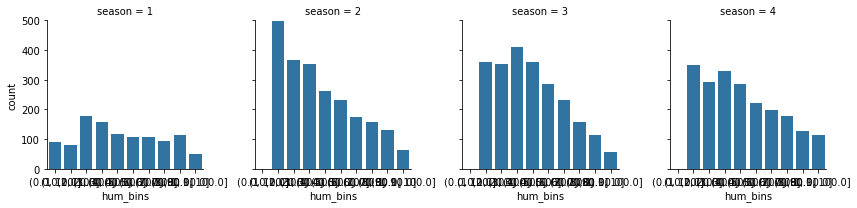

In [32]:
# Plotting humidity

g = sns.FacetGrid(humid, col = 'season', ylim = (0, 500))
g = g.map(sns.barplot, 'hum_bins', 'count')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


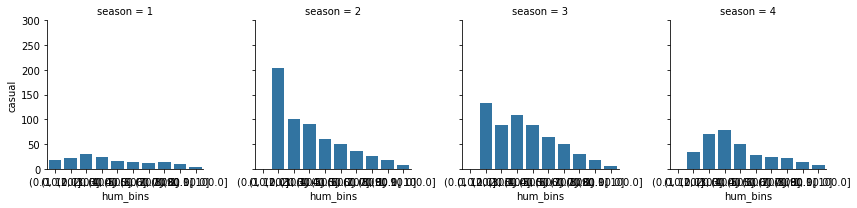

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


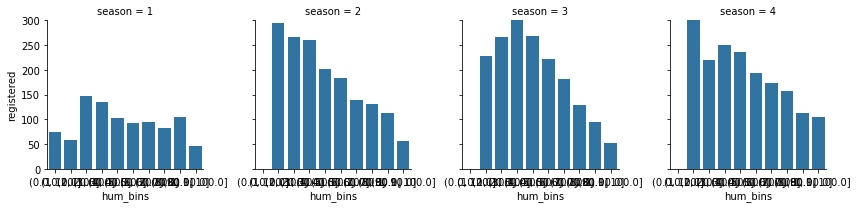

In [33]:
# Plotting humidity by ridership

g = sns.FacetGrid(humid, col = 'season', ylim = (0, 300))
g = g.map(sns.barplot, 'hum_bins', 'casual')
plt.show()

g = sns.FacetGrid(humid, col = 'season', ylim = (0, 300))
g = g.map(sns.barplot, 'hum_bins', 'registered')
plt.show()

Conclusions from these data:

- Across both ridership types, there is little relationship between humidity and rentals in spring.
- However, across both ridership types, rentals decrease as humidity rises.
- This is as I predicted.

#### Weather: Temperature

In [34]:
# find out min and max values for temp and atemp

temps = ['temp', 'atemp']

for i in temps:
    print(i)
    print(df[i].min())
    print(df[i].max())

temp
0.82
41.0
atemp
0.76
45.455


In [35]:
# Like for humidity, let's bin temp and atemp

bins_temp = pd.IntervalIndex.from_tuples([(0, 10), (10.1, 20), (20.1, 30), (30.1, 40), (40.1, 50)])

labels = ['10', '20', '30', '40', '50']

# it's the same bins and labels for the two kinds of temperature, so recycle the bins and labels
df['temp_bins'] = pd.cut(df['temp'], bins_temp)
df['atemp_bins'] = pd.cut(df['atemp'], bins_temp)

df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,date,month,year,hum_bins,temp_bins,atemp_bins
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0,2011-01-01,1,2011,"(80.1, 90.0]","(0.0, 10.0]","(10.1, 20.0]"
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,2011-01-01,1,2011,"(70.1, 80.0]","(0.0, 10.0]","(10.1, 20.0]"
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,5,2011-01-01,1,2011,"(70.1, 80.0]","(0.0, 10.0]","(10.1, 20.0]"
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,6,2011-01-01,1,2011,"(70.1, 80.0]","(0.0, 10.0]","(10.1, 20.0]"
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,7,2011-01-01,1,2011,"(80.1, 90.0]","(0.0, 10.0]","(10.1, 20.0]"


In [36]:
# New dfs that average across bins

# temp
df_temp = df.groupby(['season', 'temp_bins']).mean()

df_temp = df_temp[['count', 'casual', 'registered']]

df_temp.reset_index(inplace = True)

df_temp.head()

,season,temp_bins,count,casual,registered
0,1,"(0.0, 10.0]",72.150062,4.012300,68.137761
1,1,"(10.1, 20.0]",126.702933,17.209082,109.493851
2,1,"(20.1, 30.0]",273.692771,66.277108,207.415663
3,1,"(30.1, 40.0]",NaN,NaN,NaN
4,1,"(40.1, 50.0]",NaN,NaN,NaN


In [37]:
# same for atemp

df_Atemp = df.groupby(['season', 'atemp_bins']).mean()

df_Atemp = df_Atemp[['count', 'casual', 'registered']]

df_Atemp.reset_index(inplace = True)

df_Atemp.head()

,season,atemp_bins,count,casual,registered
0,1,"(0.0, 10.0]",66.112128,3.290618,62.821510
1,1,"(10.1, 20.0]",100.669716,9.709058,90.960659
2,1,"(20.1, 30.0]",176.795964,34.598655,142.197309
3,1,"(30.1, 40.0]",337.366667,82.883333,254.483333
4,1,"(40.1, 50.0]",NaN,NaN,NaN


/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


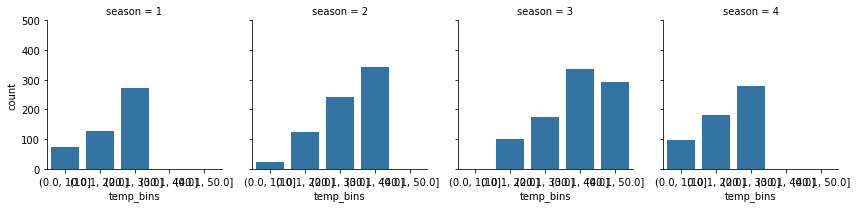

In [38]:
# Plotting temperature: Real temp

g = sns.FacetGrid(df_temp, col = 'season', ylim = (0, 500))
g = g.map(sns.barplot, 'temp_bins', 'count')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


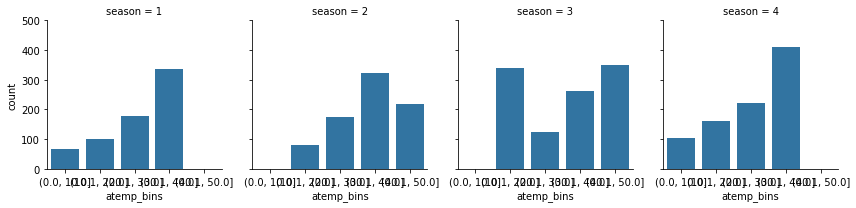

In [39]:
# Plotting temperature: Felt temp

g = sns.FacetGrid(df_Atemp, col = 'season', ylim = (0, 500))
g = g.map(sns.barplot, 'atemp_bins', 'count')
plt.show()

#### Weather plotting: Wind speed

I'm again going to plot wind speed separately by season. A strong wind is probably unpleasant no matter what the temperature, but more moderate wind speeds may vary in their effect as to whether they are warm or cold winds.

In [40]:
# What are the highest and lowest wind speeds?

df['windspeed'].describe()

count    8164.000000
mean       12.768932
std         8.178719
min         0.000000
25%         7.001500
50%        11.001400
75%        16.997900
max        56.996900
Name: windspeed, dtype: float64

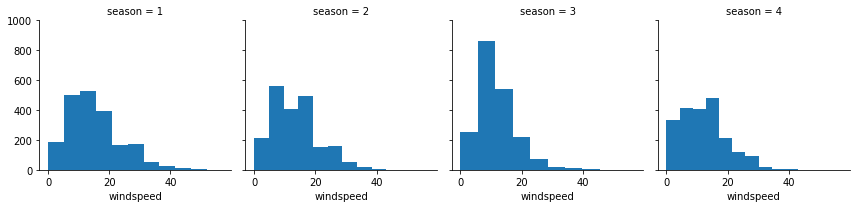

In [41]:
# Get a sense of the distribution of wind speeds in each season

g = sns.FacetGrid(df, col = 'season', ylim = (0, 1_000))
g = g.map(plt.hist, 'windspeed')
plt.show()

We see that the shape of the distribution of wind speeds doesn't differ all that much between the different seasons. In order to get much out of plotting wind speed against rental counts, I'll bin them.

In [42]:
# Binning for wind speed

# need to define some new bins
bins_wind = pd.IntervalIndex.from_tuples([(-0.1, 10), (10.1, 20), (20.1, 30), (30.1, 40), (40.1, 50), (50.1, 60)])

# create bins in new column

df['wind_bins'] = pd.cut(df['windspeed'], bins_wind)

# new df which averages within bins

df_wind = df.groupby(['season', 'wind_bins']).mean()

df_wind = df_wind[['count', 'casual', 'registered']]

df_wind.reset_index(inplace = True)

df_wind.head()

,season,wind_bins,count,casual,registered
0,1,"(-0.1, 10.0]",107.613470,13.461201,94.152269
1,1,"(10.1, 20.0]",119.860718,16.782372,103.078346
2,1,"(20.1, 30.0]",121.163569,19.219331,101.944238
3,1,"(30.1, 40.0]",130.792453,15.037736,115.754717
4,1,"(40.1, 50.0]",143.700000,17.000000,126.700000


/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


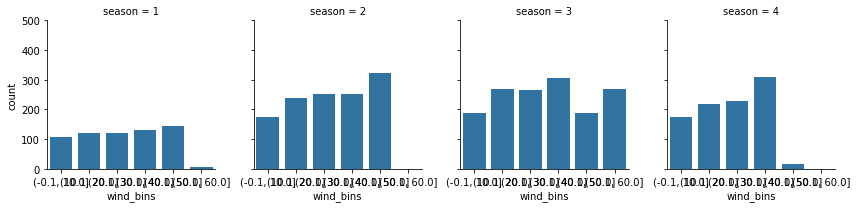

In [43]:
# Plotting wind speeds across seasons

g = sns.FacetGrid(df_wind, col = 'season', ylim = (0, 500))
g = g.map(sns.barplot, 'wind_bins', 'count')
plt.show()

### Conclusions from data exploration

What am I taking away from this to decide about feature exploration?

- Overall, there are some significant differences between casual and registered ridership patterns. This is interesting, but since the challenge is only interested in the number of bikes rented at a given time, it's not relevant to further modelling.
- Climate affects bike rental numbers in a variety of ways:
    - Generally rentals peak in summer and are lowest in spring.
    - Higher humidity is inversely correlated with rentals, but this relationship does not hold in spring.
    - Higher temperatures are correlated with rentals.
    - Season appears to interact with wind speed to impact rentals. While wind speeds above 50 still enjoy robust rental numbers in summer and autumn, rentals drop steeply for those wind speeds in winter.
- Workingday affects bike rental numbers:
    - Since holidays are a subcategory of non-workingdays, I want to focus on the workingday distinction -- holidays don't add any additional information.
    - On working days, ridership patterns diverge. Registered users tend to use a bike at rush hour.
    - On non-working days, ridership patterns are more similar, peaking unimodally around lunchtime.
- Time of day is very important in predicting bike rentals. Rentals are lowest between midnight and 5 am, but then vary throughough the day, with big peaks around rush hour times (on workdays) or lunchtime (non-workdays).
    
### Conclusions for feature engineering

- Temp and atemp: Bin
    - Include only one of these in the model; test which one works better.
- Humidity: Bin
- Wind speed: Bin
- Weather: One-hot encode
- Season is important: One-hot encode
- Workingday is important: One-hot encode
    - Include this as an interaction term as well
- Time of day: Factorise and include as categorical variable

## Step 2: Feature selection

In [44]:
# Drop casual and registered rental counts
df = df.drop(['casual', 'registered'], axis = 1)

I want to take another look at the correlated features and decide which ones to throw out. I'm using a threshold of 0.9 as suggested in this article: https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf

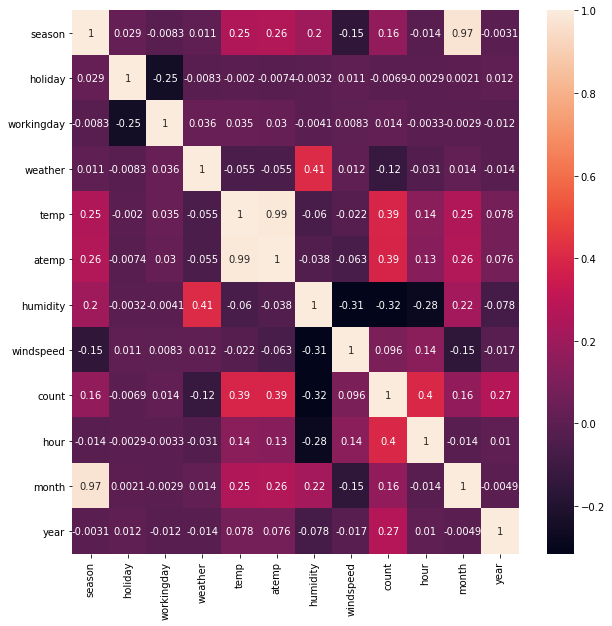

In [45]:
plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), annot = True)

We see that `temp` and `atemp` are highly correlated with each other. I'm going to select `temp`, as it does not take into account wind speed and humidity information the way that `atemp` does (see this explainer from the UK Met Office: https://blog.metoffice.gov.uk/2012/02/15/what-is-feels-like-temperature/#:~:text=We%20calculate%20a%20'feels%20like,during%20cold%20and%20windy%20days) and therefore helps me avoid multicolinearity in my features.

Additionally, `season` and `month` are highly correlated -- makes sense as one is a more coarse-grained indication of the other. I note that I'm getting a slightly higher correlation between `month` and `count` than between `season` and `count`, so I'm going to drop `season`.

In [46]:
df = df.drop(['atemp', 'season'], axis = 1)

Do we have the same amount of observations per day across all of the data? If not, we will need to impute some missing values in the feature engineering section.

In [47]:
# count number of values for each day

df['date'].value_counts()

2011-10-12    23
2012-12-02    22
2011-04-07    22
2011-11-11    22
2011-08-13    22
              ..
2012-06-16    14
2011-05-05    14
2012-05-14    13
2012-09-11    11
2011-01-18    10
Name: date, Length: 456, dtype: int64

In [48]:
# Which days have fewer than 24 data points?

investigate = df['date'].value_counts() == 24

In [49]:
investigate.value_counts()

False    456
Name: date, dtype: int64

On further thought: It doesn't especially matter if some days have fewer data points than others, since each row is complete. 



## Step 3: Feature Engineering, Feature Selection and Feature Expansion

Lesson learned from last week: Define a preprocessing pipeline that is separate from fitting a model, so that it's easier to tweak preprocessing steps.

Revision of the steps from above:

- Temp ~and atemp~: Bin
    - Decision to use only Temp, because Temp and Atemp are highly correlated
- Humidity: Bin
- Wind speed: Bin
- Weather: One-hot encode
- ~Season is important: One-hot encode~
    - Decided that month is a more fine-grained feature. Factorise, then one-hot encode.
- Workingday is important: One-hot encode
    - Include this as an interaction term as well
    - New decision: Interaction term with all of the weather categories
- Hour: Factorise, then one-hot encoding.
- Year: Initially I didn't even consider this. But actually it is important too, since the volume of bike rentals overall increases by year. So I'm going to factorise, then one-hot encode this.
- Date: I want to be able to capture the fact that as the dates get later, there tend to be more rentals overall. I will include a new 'timestep' feature that is numerical (rather than a datetime).
- Polynomials: Just for funsies, let's add some of these (degree 4)

In [50]:
Xtrain.columns, Xtest.columns

(Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
        'atemp', 'humidity', 'windspeed'],
       dtype='object'),
 Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
        'atemp', 'humidity', 'windspeed'],
       dtype='object'))

In [51]:
# It is simpler to create the various date/time columns in a separate function

def make_time_cols(df):
    df['hour'] = pd.DataFrame(pd.to_datetime(df['datetime']).dt.hour)
    df['date'] = pd.DataFrame(pd.to_datetime(df['datetime']).dt.day)
    df['month'] = pd.DataFrame(pd.to_datetime(df['datetime']).dt.month)
    df['year'] = pd.DataFrame(pd.to_datetime(df['datetime']).dt.year)
    return df

In [235]:
# Make time columns in Xtrain and Xtest

make_time_cols(Xtrain)
make_time_cols(Xtest)

Xtrain.columns, Xtest.columns

Xtrain.shape, Xtest.shape


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

((8164, 15), (2722, 15))

In [236]:
# Drop atemp column

Xtrain.drop(['atemp'], axis = 1, inplace = True)
Xtest.drop(['atemp'], axis = 1, inplace = True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [237]:
Xtrain.columns, Xtest.columns

(Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
        'humidity', 'windspeed', 'casual', 'registered', 'hour', 'date',
        'month', 'year'],
       dtype='object'),
 Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
        'humidity', 'windspeed', 'casual', 'registered', 'hour', 'date',
        'month', 'year'],
       dtype='object'))

In [55]:
####### DO NOT SORT STUFF AFTER TRAIN/TEST SPLIT.
####### WHY: Ytrain will not be sorted the same way.

# Need to sort Xtrain and Xtest chronologically in order for my timestep function below to work

# Xtrain = Xtrain.sort_values(by = 'datetime')
# Xtest = Xtest.sort_values(by = 'datetime')

In [56]:
Xtrain['date'][1]

1

In [57]:
Xtrain.head()

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,hour,date,month,year
2010,2011-05-10 16:00:00,2,0,1,1,27.06,31,7.0015,16,10,5,2011
1378,2011-04-03 07:00:00,2,0,0,1,13.12,57,15.0013,7,3,4,2011
313,2011-01-14 13:00:00,1,0,1,1,9.02,37,26.0027,13,14,1,2011
81,2011-01-04 13:00:00,1,0,1,1,9.84,56,12.9980,13,4,1,2011
6089,2012-02-09 23:00:00,1,0,1,2,12.30,52,0.0000,23,9,2,2012


In [222]:
# Define the columns that will have each kind of feature engineering

bin_cols = ['temp', 'windspeed', 'humidity']

onehot_cols = ['weather', 'workingday', 'holiday', 'hour', 'month', 'year']

timestep_cols = ['datetime']

# interaction: want to code an interaction of workingday and the weather columns

workingday_weather_cols = ['workingday', 'weather']
workingday_temp_cols = ['workingday', 'temp']
workingday_hum_cols = ['workingday', 'humidity']
workingday_wind_cols = ['workingday', 'windspeed']

# polynomiaaaallllllzzzzzz!!! Let's try some overfitting by hour and various weather features
poly_cols = ['weather', 'temp','humidity', 'windspeed', 'hour']

all_cols = ['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'humidity', 'windspeed', 'hour', 'date', 'month', 'year']

**Note to self concerning time stamps and subtracting days**

- You can subtract two items in datetime format from each other and calculate the difference between the two (e.g. in days)
- This will look like a series that includes a date-time item (see what happens when you do `steps.head()`) but it is in fact (?) just a number, the difference between the two dates (see what happens when you do `steps[59]`)

In [59]:
# code for illustration of how datetime subtraction works
# steps = (steps - pd.to_datetime(df['date'][0])).dt.days
# steps[59]

In [60]:
# Define a custom function to create a timestep
# I can't just allocate a number based on e.g. the row of the frame, because I need the timesteps to be based on the date itself.
# Subtract timestamp of first day in data set from all other days

# note that input is df (in order to work with transformer)

# first step must be defined as the earliest date in Xtrain
first_step = pd.to_datetime(Xtrain['datetime'].min())

def timestep(df): 
    '''
    Returns timestep calculated in no. days since first day in data set
    '''
   
    step = (pd.to_datetime(df.iloc[:,0]) - first_step).dt.days
    step = step.values.reshape(-1, 1)
    
    return step     
    
    

In [61]:
# check if this has the desired output
testing = timestep(Xtrain[['datetime']])
testing

# yes, it does! phew!

array([[129],
       [ 92],
       [ 13],
       ...,
       [440],
       [158],
       [459]])

### Define a feature engineering pipeline (preprocessing only)

In [62]:
onehot_transformer = Pipeline(steps = [
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

timestep_transformer = Pipeline(steps = [
    ('make_timesteps', FunctionTransformer(timestep))
])

interaction_transformer = Pipeline(steps = [
    ('create_interaction', PolynomialFeatures(interaction_only = True, include_bias = False))
])

bin_transformer = Pipeline(steps = [
    ('binning', KBinsDiscretizer(n_bins = 5))
])

polynomial_transformer = Pipeline(steps = [
    ('polynomials', PolynomialFeatures(degree = 4, include_bias = False))
])

scale_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())
])

## Question: How to make bins for specific intervals?

In [63]:
# Make preprocessing pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', onehot_transformer, onehot_cols),
        ('timestep', timestep_transformer, timestep_cols),
        ('interactions1', interaction_transformer, workingday_weather_cols),
        ('interactions2', interaction_transformer, workingday_hum_cols),
        ('interactions3', interaction_transformer, workingday_temp_cols),
        ('interactions4', interaction_transformer, workingday_wind_cols),
        ('polynomials', polynomial_transformer, poly_cols),
        ('scaling', scale_transformer, bin_cols), # the columns we want to scale are also the ones we want to bin
        ('bins', bin_transformer, bin_cols)
    ])

In [64]:
Xtrain.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'humidity', 'windspeed', 'hour', 'date', 'month', 'year'],
      dtype='object')

In [65]:
Xtest.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'humidity', 'windspeed', 'hour', 'date', 'month', 'year'],
      dtype='object')

In [66]:
Xtrain_prep = preprocessor.fit_transform(Xtrain)
Xtest_prep = preprocessor.transform(Xtest)

In [67]:
Xtrain_prep.shape, Xtest_prep.shape

((8164, 202), (2722, 202))

## Fit a baseline model

- Establish a null model, which is generally useful

In [218]:
m_base = DummyRegressor(strategy='median')
m_base.fit(Xtrain_prep, ytrain)
y_pred_base = m_base.predict(Xtrain_prep)

In [219]:
f'Training accuracy: {m_base.score(Xtrain_prep, ytrain)}'

'Training accuracy: -0.06586849951009222'

In [220]:
f'Training accuracy: {m_base.score(Xtest_prep, ytest)}'

'Training accuracy: -0.06686997025014985'

Preliminary conclusions: this baseline model is terrible!

## Recursive Feature Elimination

https://machinelearningmastery.com/rfe-feature-selection-in-python/

https://stackoverflow.com/questions/47730328/extract-optimal-features-from-recursive-feature-elimination-rfe

In [71]:
# adapted from textbook

rfe = RFE(estimator = LinearRegression(), n_features_to_select = 50)
rfe.fit(Xtrain_prep, ytrain)

RFE(estimator=LinearRegression(), n_features_to_select=50)

In [72]:
# summarise all features
for i in range(Xtrain_prep.shape[1]-1):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 28.000
Column: 1, Selected False, Rank: 27.000
Column: 2, Selected False, Rank: 26.000
Column: 3, Selected False, Rank: 25.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected True, Rank: 1.000
Column: 11, Selected True, Rank: 1.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected True, Rank: 1.000
Column: 14, Selected True, Rank: 1.000
Column: 15, Selected True, Rank: 1.000
Column: 16, Selected True, Rank: 1.000
Column: 17, Selected True, Rank: 1.000
Column: 18, Selected True, Rank: 1.000
Column: 19, Selected True, Rank: 1.000
Column: 20, Selected True, Rank: 1.000
Column: 21, Selected True, Rank: 1.000
Column: 22, Selected True, Rank: 1.000
Column: 23, Selected True, Rank: 1.000
Column: 24, Selected True, Rank: 1.000
Column: 25, Selected True, 

In [73]:
summary_features = rfe.get_support(1)
summary_features

array([  4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
        17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  47,  48,  50,  51,  53,  54,  56,  59,  60,  61,  63,
        64,  65,  66,  68,  79,  80,  81,  83, 116, 118, 184])

In [74]:
summary_features.shape

(50,)

In [75]:

Xtrain_prep

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [76]:
# slice out just the features we selected in the RFE process

Xtrain_prep_rfe = Xtrain_prep[:, summary_features]
Xtest_prep_rfe = Xtest_prep[:, summary_features]

In [77]:
Xtrain_prep_rfe.shape, Xtest_prep_rfe.shape

((8164, 50), (2722, 50))

In [78]:
m_rfe = LinearRegression()

m_rfe.fit(Xtrain_prep_rfe, ytrain)

LinearRegression()

In [79]:
m_rfe.score(Xtrain_prep_rfe, ytrain)

0.6141163009066961

In [80]:
m_rfe.score(Xtest_prep_rfe, ytest)

0.6182152888215922

### Cross-validation for model with RFE

In [112]:
cross_val_score(m_rfe, Xtrain_prep_rfe, ytrain, cv=5, scoring='r2')

array([ 6.09603174e-01,  6.06219275e-01,  6.14734684e-01,  6.10665982e-01,
       -3.95944561e+17])

The first four scores look pretty much in line with each other... but the last one looks horrific?!

I'm going to redo the RFE and select far fewer features.

## RFE, take 2

In [173]:
rfe2 = RFE(estimator = LinearRegression(), n_features_to_select = 15)
rfe2.fit(Xtrain_prep, ytrain)

RFE(estimator=LinearRegression(), n_features_to_select=15)

In [174]:
summary_features_2 = rfe2.get_support(1)

In [155]:
summary_features_2

array([ 8,  9, 10, 11, 12, 13, 14, 16, 20, 21, 24, 25, 26, 27, 31])

In [156]:
Xtrain_prep_rfe2 = Xtrain_prep[: , summary_features_2]
Xtest_prep_rfe2 = Xtest_prep[: , summary_features_2]

In [157]:
Xtrain_prep_rfe2.shape, Xtest_prep_rfe2.shape

((8164, 15), (2722, 15))

In [158]:
m_rfe2 = LinearRegression()

In [159]:
m_rfe2.fit(Xtrain_prep_rfe2, ytrain)

LinearRegression()

In [160]:
m_rfe2.score(Xtrain_prep_rfe2, ytrain)

0.49633675480360007

### Cross-validation, round 2

In [162]:
cross_val_score(m_rfe2, Xtrain_prep_rfe2, ytrain, cv=5, scoring='r2')

In [182]:
# run RFE with different numbers of features


cv_scores = []

for i in range(1, 30):
    rfe_temp = RFE(estimator = LinearRegression(), n_features_to_select = i)
    rfe_temp.fit(Xtrain_prep, ytrain)
    sum_feat_temp = rfe_temp.get_support(1)
    Xtrain_temp = Xtrain_prep[: , sum_feat_temp]
    Xtest_temp = Xtest_prep[: , sum_feat_temp]
    
    m_rfe_temp = LinearRegression()
    m_rfe_temp.fit(Xtrain_temp, ytrain)
    
    cv_mean = cross_val_score(m_rfe_temp, Xtrain_temp, ytrain, cv=5, scoring='r2').mean()
    cv_scores.append(cv_mean)
    print(cv_scores)
    
#cv_scores

In [197]:
# Plot improvement of RFE as features increase

no_iter = [range(1, 30)]

score_df = pd.DataFrame(cv_scores)
score_df.columns = ['score']
score_df.head()

,score
0,0.101018
1,0.183706
2,0.215485
3,0.250044
4,0.286662


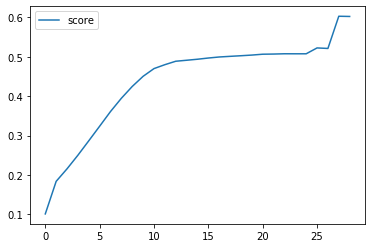

In [200]:
# plot score improvement

sns.lineplot(data = score_df)

## Experiment with PCA

In [238]:
# scale everything: incorporate in new preprocessor

preprocessor_PCA = ColumnTransformer(
    transformers=[
        ('onehot', onehot_transformer, onehot_cols),
        ('timestep', timestep_transformer, timestep_cols),
        ('interactions1', interaction_transformer, workingday_weather_cols),
        ('interactions2', interaction_transformer, workingday_hum_cols),
        ('interactions3', interaction_transformer, workingday_temp_cols),
        ('interactions4', interaction_transformer, workingday_wind_cols),
        ('polynomials', polynomial_transformer, poly_cols),
        ('scaling', scale_transformer, bin_cols), # the columns we want to scale are also the ones we want to bin
        ('bins', bin_transformer, bin_cols),
        ('scaling_for_PCA', scale_transformer, all_cols)
    ])


In [239]:
Xtrain_PCA_prep = preprocessor_PCA.fit_transform(Xtrain)

Xtest_PCA_prep = preprocessor_PCA.transform(Xtest)

ValueError: could not convert string to float: '2012-11-11 13:00:00'

In [209]:
Xtrain_PCA_prep.shape

(8164, 207)

In [210]:
pca = PCA(n_components = 10)
pca.fit_transform(Xtrain_PCA_prep)

array([[-2.34344306e+07, -1.51805472e+06,  1.57463421e+04, ...,
         1.65213849e+05, -7.33210562e+04, -2.62263435e+04],
       [-1.34339686e+07, -6.34868287e+05,  1.67866763e+06, ...,
        -1.10362730e+05,  1.78267007e+04, -3.23227777e+04],
       [-2.24676816e+07, -9.02478801e+05,  1.58131274e+06, ...,
         8.06310548e+04, -2.06170911e+04,  1.34095208e+05],
       ...,
       [ 5.60583246e+07, -5.45829379e+05, -8.43906837e+06, ...,
        -2.43023104e+05,  1.93342102e+05, -9.91370393e+05],
       [ 3.75085249e+07, -5.26297179e+06, -6.56368556e+06, ...,
         3.87264891e+05,  4.01652521e+05,  4.48818382e+05],
       [-2.01457296e+07,  4.54888853e+05,  7.04312760e+03, ...,
        -1.71819666e+05, -1.37617953e+05,  3.01743609e+04]])

In [211]:
pca.explained_variance_ratio_

array([9.51351414e-01, 1.90532961e-02, 1.39241103e-02, 1.32837841e-02,
       8.64985211e-04, 6.30985930e-04, 2.08002573e-04, 1.65935092e-04,
       1.24607818e-04, 1.18809080e-04])

In [212]:
len(pca.explained_variance_ratio_)

10

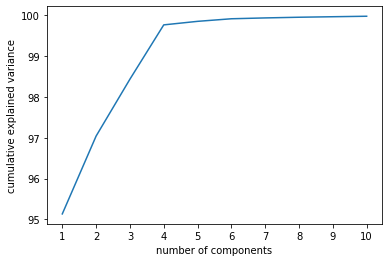

In [213]:
# copy-pasted from Paula's notebook

plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xticks(np.arange(len(pca.explained_variance_ratio_)), np.arange(1,len(pca.explained_variance_ratio_)+1)) 
plt.show()

In [204]:
## hmmm... not so useful. let's cut it down to the first few components
#
#plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
#plt.xlim(-1, 10)
#plt.ylim(50, 100)
#plt.xlabel('number of components')
#plt.ylabel('cumulative explained variance')
## plt.xticks(np.arange(len(pca.explained_variance_ratio_)), np.arange(1,len(pca.explained_variance_ratio_)+1)) 
#plt.show()

## Use PCA model to train linear regression: the Paula way

In [214]:
# transform Xtrain_PCA_prep and Xtest_PCA_prep according to pca
Xtrain_PCA = pca.fit_transform(Xtrain_PCA_prep)
Xtest_PCA = pca.transform(Xtest_PCA_prep)

In [215]:
# Set up linear regression model

m_pca = LinearRegression()

# train model

m_pca.fit(Xtrain_PCA, ytrain)

LinearRegression()

In [216]:
m_pca.score(Xtest_PCA, ytest)

0.2522997728310029

## Cross-validation with PCA model

In [217]:
cross_val_score(m_pca, Xtrain_PCA, ytrain, cv=5, scoring='r2')

array([0.23889264, 0.28235364, 0.25998112, 0.25823444, 0.30264509])

Question: Is a 6% variation a sign that the model is overfitting?

## Use PCA library to train linear regression

from Stack Overflow: https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot

In [201]:
# pip install pca

[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed on the [202] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


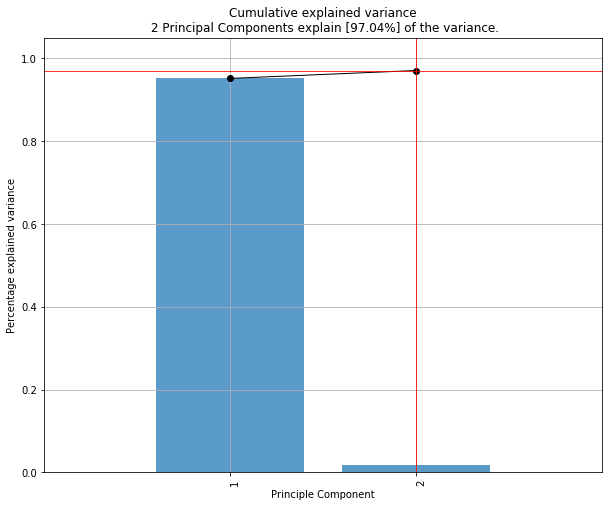

<Figure size 432x288 with 0 Axes>

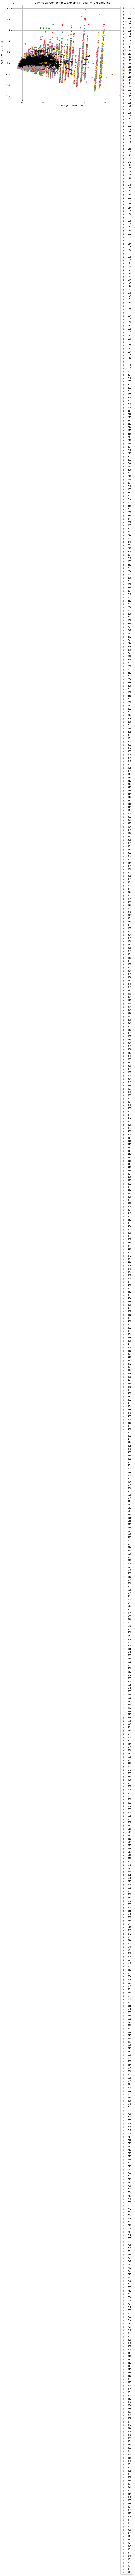

In [106]:
from pca import pca

# Initialize to reduce the data up to the number of components that explains 95% of the variance.
model = pca(n_components=0.95)

# Or reduce the data towards 2 PCs
model = pca(n_components=2)

# Fit transform
results = model.fit_transform(Xtrain_prep, ytrain)

# Plot explained variance
fig, ax = model.plot()

# Scatter first 2 PCs
# fig, ax = model.scatter()

# Make biplot with the number of features
fig, ax = model.biplot(n_feat=4)

In [ ]:
# train 